##1. CHECKPOINT CLEANER

Menghapus checkpoint lama untuk training ulang dari awal

Set AUTO_DELETE = True untuk menghapus otomatis



In [1]:

import os
import shutil
from datetime import datetime

print("="*70)
print("🗑️  CHECKPOINT CLEANER")
print("="*70)

checkpoint_dir = '/content/drive/MyDrive/ML/checkpoints'
backup_dir = '/content/drive/MyDrive/ML/checkpoints_backup_' + datetime.now().strftime('%Y%m%d_%H%M%S')

# Check if checkpoints exist
checkpoint_files = [
    'best_custom_cnn.h5',
    'best_transfer_phase1.h5',
    'best_transfer_final.h5'
]

existing_checkpoints = []
for file in checkpoint_files:
    path = os.path.join(checkpoint_dir, file)
    if os.path.exists(path):
        existing_checkpoints.append(file)

if not existing_checkpoints:
    print("✅ No checkpoints found. Training will start fresh!")
else:
    print(f"⚠️  Found {len(existing_checkpoints)} checkpoint(s):")
    for file in existing_checkpoints:
        print(f"   - {file}")

    # ASK USER (change to True to auto-delete)
    AUTO_DELETE = False  # ← CHANGE TO True TO AUTO-DELETE!

    if AUTO_DELETE:
        print("\n🔄 Auto-delete enabled. Backing up and deleting...")

        # Backup
        if os.path.exists(checkpoint_dir):
            shutil.copytree(checkpoint_dir, backup_dir)
            print(f"✅ Backup created: {backup_dir}")

        # Delete
        for file in existing_checkpoints:
            path = os.path.join(checkpoint_dir, file)
            os.remove(path)
            print(f"🗑️  Deleted: {file}")

        # Delete metadata files
        metadata_files = [
            'custom_cnn_metadata.json',
            'transfer_phase1_metadata.json',
            'transfer_finetune_metadata.json',
            'custom_cnn_history.json',
            'transfer_phase1_history.json',
            'transfer_finetune_history.json'
        ]

        for file in metadata_files:
            path = os.path.join(checkpoint_dir, file)
            if os.path.exists(path):
                os.remove(path)
                print(f"🗑️  Deleted: {file}")

        print("\n✅ ✅ ✅ CHECKPOINTS DELETED!")
        print("   Next training will start FROM SCRATCH with class weights!")
    else:
        print("\n⏭️  Auto-delete disabled (AUTO_DELETE = False)")
        print("   Change AUTO_DELETE = True to enable")
        print("   Checkpoints will be loaded and training may skip!")

print("="*70)

🗑️  CHECKPOINT CLEANER
⚠️  Found 3 checkpoint(s):
   - best_custom_cnn.h5
   - best_transfer_phase1.h5
   - best_transfer_final.h5

⏭️  Auto-delete disabled (AUTO_DELETE = False)
   Change AUTO_DELETE = True to enable
   Checkpoints will be loaded and training may skip!


##2. IMPORT LIBRARIES & GPU SETUP

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import glob
import json
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow Version: {tf.__version__}")

# GPU Setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU ACTIVE: {gpus[0].name}")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️  WARNING: No GPU detected!")

TensorFlow Version: 2.19.0
✅ GPU ACTIVE: /physical_device:GPU:0


##3. MOUNT GOOGLE DRIVE & DATASET CONFIGURATION

In [3]:
print("\n" + "="*70)
print("DATASET CONFIGURATION")
print("="*70)

from google.colab import drive
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/ML'  # ⚠️ UBAH INI!
train_dir = os.path.join(base_path, 'train')
val_dir = os.path.join(base_path, 'val')
test_dir = os.path.join(base_path, 'test')
checkpoint_dir = os.path.join(base_path, 'checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)

# Verify
print(f"Base Path: {base_path}")
print(f"Checkpoint Dir: {checkpoint_dir}")
for path, name in [(train_dir, 'Train'), (val_dir, 'Val'), (test_dir, 'Test')]:
    if os.path.exists(path):
        n = len([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])
        print(f"✅ {name}: {n} classes")


DATASET CONFIGURATION
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Base Path: /content/drive/MyDrive/ML
Checkpoint Dir: /content/drive/MyDrive/ML/checkpoints
✅ Train: 31 classes
✅ Val: 31 classes
✅ Test: 31 classes


##4. CHECKPOINT & RESUME TRAINING SYSTEM

In [4]:
class SmartCheckpoint(keras.callbacks.Callback):
    """Save checkpoint with metadata every N epochs"""
    def __init__(self, checkpoint_dir, model_name, save_freq=5):
        super().__init__()
        self.checkpoint_dir = checkpoint_dir
        self.model_name = model_name
        self.save_freq = save_freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            model_path = os.path.join(self.checkpoint_dir, f'{self.model_name}_epoch_{epoch+1:03d}.h5')
            self.model.save(model_path)

            meta_path = os.path.join(self.checkpoint_dir, f'{self.model_name}_metadata.json')
            metadata = {
                'last_epoch': epoch + 1,
                'last_checkpoint': model_path,
                'metrics': {k: float(v) for k, v in logs.items()}
            }
            with open(meta_path, 'w') as f:
                json.dump(metadata, f, indent=2)

            print(f"\n💾 Checkpoint saved: Epoch {epoch+1} | Val Acc: {logs.get('val_accuracy', 0):.4f}")

            # Keep only last 3 checkpoints
            checkpoints = sorted(glob.glob(os.path.join(self.checkpoint_dir, f'{self.model_name}_epoch_*.h5')))
            for old in checkpoints[:-3]:
                try:
                    os.remove(old)
                except:
                    pass

class HistorySaver(keras.callbacks.Callback):
    """Save training history incrementally"""
    def __init__(self, save_path, previous_history=None):
        super().__init__()
        self.save_path = save_path
        self.history_data = previous_history if previous_history else {}

    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            if k not in self.history_data:
                self.history_data[k] = []
            self.history_data[k].append(float(v))
        with open(self.save_path, 'w') as f:
            json.dump(self.history_data, f, indent=2)

def check_and_resume(model_name, checkpoint_dir):
    """Check for existing checkpoint and resume"""
    print(f"\n🔍 Checking checkpoint: {model_name}")

    meta_path = os.path.join(checkpoint_dir, f'{model_name}_metadata.json')

    if not os.path.exists(meta_path):
        print("❌ No checkpoint found. Starting fresh.")
        return None, 0, None

    with open(meta_path, 'r') as f:
        metadata = json.load(f)

    last_epoch = metadata['last_epoch']
    checkpoint_path = metadata['last_checkpoint']

    print(f"✅ Found checkpoint: Epoch {last_epoch}")
    print(f"   File: {os.path.basename(checkpoint_path)}")

    try:
        model = keras.models.load_model(checkpoint_path)
        print(f"✅ Model loaded!")

        history_path = os.path.join(checkpoint_dir, f'{model_name}_history.json')
        history_data = None
        if os.path.exists(history_path):
            with open(history_path, 'r') as f:
                history_data = json.load(f)
            print(f"✅ History loaded")

        return model, last_epoch, history_data
    except Exception as e:
        print(f"❌ Load failed: {e}")
        return None, 0, None

print("\n✅ Auto-checkpoint system ready!")


✅ Auto-checkpoint system ready!


##5. DATASET ANALYSIS & VISUALIZATION


DATASET ANALYSIS
Training: 8801 images
Validation: 2751 images
Test: 1760 images


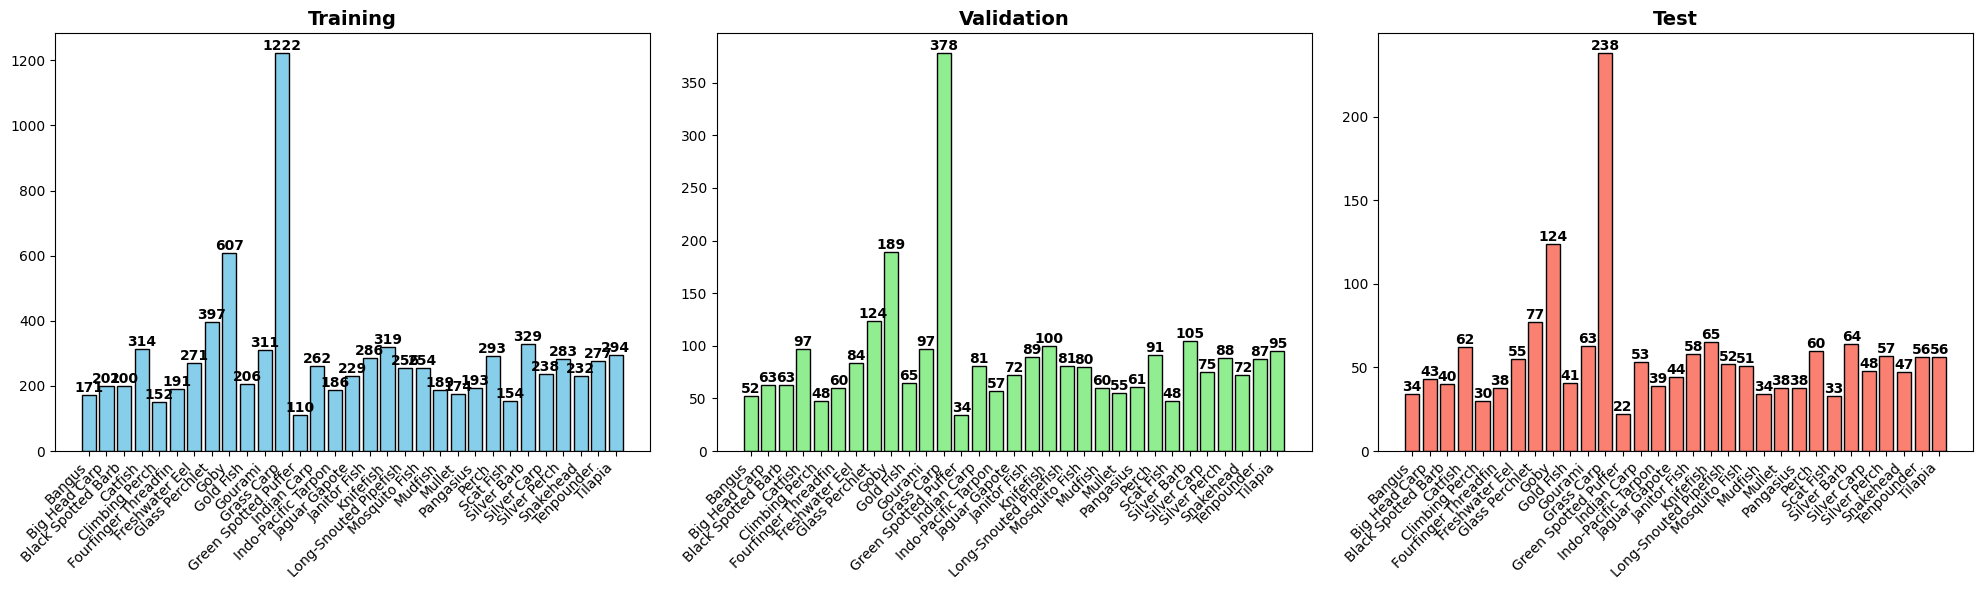

In [5]:
print("\n" + "="*70)
print("DATASET ANALYSIS")
print("="*70)

def analyze_dataset(directory):
    classes = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    class_counts = {}
    for cls in classes:
        cls_path = os.path.join(directory, cls)
        count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[cls] = count
    return class_counts

train_dist = analyze_dataset(train_dir)
val_dist = analyze_dataset(val_dir)
test_dist = analyze_dataset(test_dir)

print(f"Training: {sum(train_dist.values())} images")
print(f"Validation: {sum(val_dist.values())} images")
print(f"Test: {sum(test_dist.values())} images")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for idx, (data, title, color) in enumerate([
    (train_dist, 'Training', 'skyblue'),
    (val_dist, 'Validation', 'lightgreen'),
    (test_dist, 'Test', 'salmon')
]):
    axes[idx].bar(range(len(data)), list(data.values()), color=color, edgecolor='black')
    axes[idx].set_title(title, fontsize=14, fontweight='bold')
    axes[idx].set_xticks(range(len(data)))
    axes[idx].set_xticklabels(list(data.keys()), rotation=45, ha='right')
    for i, v in enumerate(data.values()):
        axes[idx].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

##6. DATA PREPROCESSING & AUGMENTATION

In [6]:
print("\n" + "="*70)
print("DATA PREPROCESSING")
print("="*70)

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

print(f"✅ Classes: {num_classes}")
print(f"   {class_names}")


DATA PREPROCESSING
Found 8801 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1760 images belonging to 31 classes.
✅ Classes: 31
   ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']


##7. CLASS WEIGHT COMPUTATION

In [7]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

##8. CLASS WEIGHT CALCULATION WITH ANALYSIS

In [8]:
# ===================================================================
# FIX: CALCULATE CLASS WEIGHTS
# ===================================================================
print("\n" + "="*70)
print("CALCULATING CLASS WEIGHTS (FIX IMBALANCE)")
print("="*70)

from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

print(f"✅ Class weights calculated!")
print(f"   Min weight: {min(class_weights):.4f}")
print(f"   Max weight: {max(class_weights):.4f}")
print(f"   Ratio: {max(class_weights)/min(class_weights):.2f}x")

# Show top 5 classes with highest weights
sorted_weights = sorted(class_weight_dict.items(), key=lambda x: x[1], reverse=True)
print(f"\n📊 Top 5 smallest classes (need more attention):")
for idx, weight in sorted_weights[:5]:
    class_name = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(idx)]
    print(f"   Class {idx} ({class_name}): weight = {weight:.4f}")

print("\n✅ Class weights ready to use!")
print("="*70)



CALCULATING CLASS WEIGHTS (FIX IMBALANCE)
✅ Class weights calculated!
   Min weight: 0.2323
   Max weight: 2.5809
   Ratio: 11.11x

📊 Top 5 smallest classes (need more attention):
   Class 12 (Green Spotted Puffer): weight = 2.5809
   Class 4 (Climbing Perch): weight = 1.8678
   Class 24 (Scat Fish): weight = 1.8435
   Class 0 (Bangus): weight = 1.6603
   Class 21 (Mullet): weight = 1.6316

✅ Class weights ready to use!


##9. CUSTOM CNN TRAINING (BASELINE MODEL)


CUSTOM CNN - WITH AUTO-RESUME

🔍 Checking checkpoint: custom_cnn
✅ Found checkpoint: Epoch 20
   File: custom_cnn_epoch_020.h5


✅ Model loaded!
✅ History loaded
🔄 Recompiling loaded model...
✅ Model recompiled and ready!

🚀 Training from epoch 20 to 20
✅ Custom CNN done: 0.74 min

✅ Custom CNN already completed in previous run!
   Loading history from file...


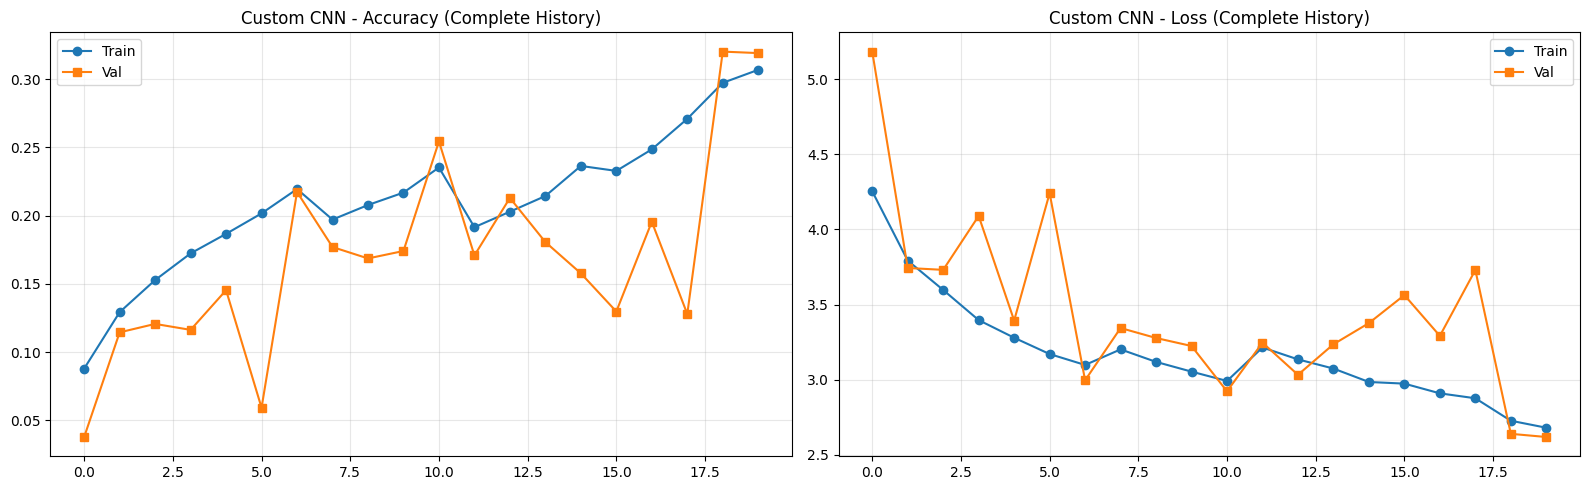

✅ History loaded: 20 epochs (displayed)
   (Original file has 26 epochs)


In [9]:
print("\n" + "="*70)
print("CUSTOM CNN - WITH AUTO-RESUME")
print("="*70)

# Check for checkpoint
custom_cnn, initial_epoch_cnn, history_cnn_prev = check_and_resume('custom_cnn', checkpoint_dir)

# Build if no checkpoint
if custom_cnn is None:
    print("🏗️  Building Custom CNN...")
    custom_cnn = models.Sequential([
        layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),

        layers.Dense(512, kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    custom_cnn.compile(
        optimizer=keras.optimizers.Adam(0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print("✅ Model built")
else:
    # ✅ FIX: Recompile loaded model
    print("🔄 Recompiling loaded model...")
    custom_cnn.compile(
        optimizer=keras.optimizers.Adam(0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print("✅ Model recompiled and ready!")

EPOCHS_CNN = 20

callbacks_cnn = [
    SmartCheckpoint(checkpoint_dir, 'custom_cnn', save_freq=5),
    HistorySaver(os.path.join(checkpoint_dir, 'custom_cnn_history.json'), history_cnn_prev),
    EarlyStopping(patience=10, restore_best_weights=True, verbose=1, monitor='val_accuracy', mode='max'),
    ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-7, verbose=1),
    ModelCheckpoint(os.path.join(checkpoint_dir, 'best_custom_cnn.h5'),
                   save_best_only=True, verbose=1, monitor='val_accuracy', mode='max')
]

print(f"\n🚀 Training from epoch {initial_epoch_cnn} to {EPOCHS_CNN}")
start_time = time.time()

history_cnn = custom_cnn.fit(
    train_generator,
    epochs=EPOCHS_CNN,
    initial_epoch=initial_epoch_cnn,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks_cnn,
    verbose=1
)

cnn_time = (time.time() - start_time) / 60
print(f"✅ Custom CNN done: {cnn_time:.2f} min")

gc.collect()
tf.keras.backend.clear_session()

# Visualize
# Check if history has data
if history_cnn.history and len(history_cnn.history.get('accuracy', [])) > 0:
    # Visualize current training
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    axes[0].plot(history_cnn.history['accuracy'], label='Train', marker='o')
    axes[0].plot(history_cnn.history['val_accuracy'], label='Val', marker='s')
    axes[0].set_title('Custom CNN - Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history_cnn.history['loss'], label='Train', marker='o')
    axes[1].plot(history_cnn.history['val_loss'], label='Val', marker='s')
    axes[1].set_title('Custom CNN - Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\n✅ Custom CNN already completed in previous run!")
    print("   Loading history from file...")

    # Load from saved history
history_path = os.path.join(checkpoint_dir, 'custom_cnn_history.json')
if os.path.exists(history_path):
    with open(history_path, 'r') as f:
        history_data = json.load(f)

    # ✅ FIX: Slice hanya 20 epochs pertama
    max_epochs = 20
    history_data_sliced = {
        'accuracy': history_data['accuracy'][:max_epochs],
        'val_accuracy': history_data['val_accuracy'][:max_epochs],
        'loss': history_data['loss'][:max_epochs],
        'val_loss': history_data['val_loss'][:max_epochs]
    }

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    axes[0].plot(history_data_sliced['accuracy'], label='Train', marker='o')
    axes[0].plot(history_data_sliced['val_accuracy'], label='Val', marker='s')
    axes[0].set_title('Custom CNN - Accuracy (Complete History)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history_data_sliced['loss'], label='Train', marker='o')
    axes[1].plot(history_data_sliced['val_loss'], label='Val', marker='s')
    axes[1].set_title('Custom CNN - Loss (Complete History)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"✅ History loaded: {len(history_data_sliced['accuracy'])} epochs (displayed)")
    print(f"   (Original file has {len(history_data['accuracy'])} epochs)")


##10. TRANSFER LEARNING PHASE 1 (FEATURE EXTRACTION)

In [10]:
# ===================================================================
# TRANSFER LEARNING PHASE 1
# ===================================================================
print("\n" + "="*70)
print("TRANSFER LEARNING PHASE 1 ")
print("="*70)

# Check for existing checkpoint
transfer_model, initial_epoch_t1, history_t1_prev = check_and_resume('transfer_phase1', checkpoint_dir)

if transfer_model is None:
    # Build new model
    print("🏗️  Building Transfer Learning model...")
    base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                             include_top=False, weights='imagenet')
    base_model.trainable = False

    transfer_model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    transfer_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print("✅ Transfer model built")

else:
    # ===================================================================
    # FIX: RECOMPILE LOADED MODEL TO ENABLE EAGER EXECUTION
    # ===================================================================
    print("🔄 Model loaded from checkpoint. Recompiling...")

    # Enable eager execution (fix numpy error)
    import tensorflow as tf
    tf.config.run_functions_eagerly(True)

    # Recompile with fresh optimizer
    transfer_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("✅ Model recompiled successfully!")
    print(f"   Resuming from epoch {initial_epoch_t1}")
    # ===================================================================

# Training configuration
EPOCHS_T1 = 25

# Callbacks
callbacks_t1 = [
    SmartCheckpoint(checkpoint_dir, 'transfer_phase1', save_freq=5),
    HistorySaver(os.path.join(checkpoint_dir, 'transfer_phase1_history.json'), history_t1_prev),
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        patience=4,
        factor=0.5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        os.path.join(checkpoint_dir, 'best_transfer_phase1.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

# Start training
print(f"\n🚀 Training Phase 1: Epoch {initial_epoch_t1} to {EPOCHS_T1}")
start_time = time.time()

history_t1 = transfer_model.fit(
    train_generator,
    epochs=EPOCHS_T1,
    initial_epoch=initial_epoch_t1,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks_t1,
    verbose=1
)

t1_time = (time.time() - start_time) / 60
print(f"\n✅ Phase 1 completed: {t1_time:.2f} minutes")



TRANSFER LEARNING PHASE 1 

🔍 Checking checkpoint: transfer_phase1
✅ Found checkpoint: Epoch 25
   File: transfer_phase1_epoch_025.h5


✅ Model loaded!
✅ History loaded
🔄 Model loaded from checkpoint. Recompiling...
✅ Model recompiled successfully!
   Resuming from epoch 25

🚀 Training Phase 1: Epoch 25 to 25

✅ Phase 1 completed: 0.69 minutes


##11. TRANSFER LEARNING PHASE 2 (FINE-TUNING)

In [11]:
print("\n" + "="*70)
print("TRANSFER LEARNING PHASE 2 (FINE-TUNING)")
print("="*70)

transfer_ft, initial_epoch_t2, history_t2_prev = check_and_resume('transfer_finetune', checkpoint_dir)

if transfer_ft is None:
    print("🔓 Unfreezing layers...")
    phase1_path = os.path.join(checkpoint_dir, 'best_transfer_phase1.h5')
    if os.path.exists(phase1_path):
        transfer_ft = keras.models.load_model(phase1_path)
    else:
        transfer_ft = transfer_model

    base_model_ft = transfer_ft.layers[0]
    base_model_ft.trainable = True
    fine_tune_at = len(base_model_ft.layers) - 30

    for layer in base_model_ft.layers[:fine_tune_at]:
        layer.trainable = False

    print(f"   Trainable: {len(base_model_ft.layers) - fine_tune_at} layers")

    transfer_ft.compile(optimizer=keras.optimizers.Adam(0.0001),
                       loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS_T2 = 15

callbacks_t2 = [
    SmartCheckpoint(checkpoint_dir, 'transfer_finetune', save_freq=5),
    HistorySaver(os.path.join(checkpoint_dir, 'transfer_finetune_history.json'), history_t2_prev),
    EarlyStopping(patience=8, restore_best_weights=True, verbose=1, monitor='val_accuracy', mode='max'),
    ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-8, verbose=1),
    ModelCheckpoint(os.path.join(checkpoint_dir, 'best_transfer_final.h5'),
                   save_best_only=True, verbose=1, monitor='val_accuracy', mode='max')
]

print(f"🚀 Fine-tuning from epoch {initial_epoch_t2} to {EPOCHS_T2}")
start_time = time.time()

history_t2 = transfer_ft.fit(
    train_generator,
    epochs=EPOCHS_T2,
    initial_epoch=initial_epoch_t2,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks_t2,
    verbose=1
)

t2_time = (time.time() - start_time) / 60
print(f"✅ Phase 2 done: {t2_time:.2f} min")

total_time = cnn_time + t1_time + t2_time
print(f"\n⏱️  TOTAL TRAINING TIME: {total_time:.2f} minutes ({total_time/60:.2f} hours)")


TRANSFER LEARNING PHASE 2 (FINE-TUNING)

🔍 Checking checkpoint: transfer_finetune
✅ Found checkpoint: Epoch 15
   File: transfer_finetune_epoch_015.h5


✅ Model loaded!
✅ History loaded
🚀 Fine-tuning from epoch 15 to 15
✅ Phase 2 done: 0.69 min

⏱️  TOTAL TRAINING TIME: 2.12 minutes (0.04 hours)


##12. VERIFY TEST DATASET COMPLETENESS

In [12]:
# ===================================================================
# VERIFY NEW TEST DATASET
# ===================================================================
print("="*70)
print("VERIFYING NEW TEST DATASET")
print("="*70)

# Check test folder
test_classes = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])
print(f"\nClasses in test folder: {len(test_classes)}")

total_images = 0
classes_with_images = 0

for cls in test_classes:
    cls_path = os.path.join(test_dir, cls)
    count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    total_images += count
    if count > 0:
        classes_with_images += 1
        print(f"  ✅ {cls}: {count} images")
    else:
        print(f"  ❌ {cls}: 0 images (EMPTY!)")

print(f"\n{'='*70}")
print(f"SUMMARY:")
print(f"  Total classes: {len(test_classes)}")
print(f"  Classes with images: {classes_with_images}")
print(f"  Total images: {total_images}")

if len(test_classes) == 31 and classes_with_images == 31 and total_images >= 93:
    print(f"  ✅✅✅ TEST DATASET COMPLETE!")
else:
    print(f"  ⚠️  Test dataset still incomplete")
    if len(test_classes) < 31:
        print(f"     Missing {31 - len(test_classes)} class folders")
    if classes_with_images < 31:
        print(f"     {31 - classes_with_images} classes have no images")
print("="*70)


VERIFYING NEW TEST DATASET

Classes in test folder: 31
  ✅ Bangus: 34 images
  ✅ Big Head Carp: 43 images
  ✅ Black Spotted Barb: 40 images
  ✅ Catfish: 62 images
  ✅ Climbing Perch: 30 images
  ✅ Fourfinger Threadfin: 38 images
  ✅ Freshwater Eel: 55 images
  ✅ Glass Perchlet: 77 images
  ✅ Goby: 124 images
  ✅ Gold Fish: 41 images
  ✅ Gourami: 63 images
  ✅ Grass Carp: 238 images
  ✅ Green Spotted Puffer: 22 images
  ✅ Indian Carp: 53 images
  ✅ Indo-Pacific Tarpon: 39 images
  ✅ Jaguar Gapote: 44 images
  ✅ Janitor Fish: 58 images
  ✅ Knifefish: 65 images
  ✅ Long-Snouted Pipefish: 52 images
  ✅ Mosquito Fish: 51 images
  ✅ Mudfish: 34 images
  ✅ Mullet: 38 images
  ✅ Pangasius: 38 images
  ✅ Perch: 60 images
  ✅ Scat Fish: 33 images
  ✅ Silver Barb: 64 images
  ✅ Silver Carp: 48 images
  ✅ Silver Perch: 57 images
  ✅ Snakehead: 47 images
  ✅ Tenpounder: 56 images
  ✅ Tilapia: 56 images

SUMMARY:
  Total classes: 31
  Classes with images: 31
  Total images: 1760
  ✅✅✅ TEST DATASET C

##13. RECREATE TEST GENERATOR

In [13]:
# ===================================================================
# RECREATE TEST GENERATOR
# ===================================================================
print("\n" + "="*70)
print("RECREATING TEST GENERATOR")
print("="*70)

# Recreate test generator (auto-match class order)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\n✅ Test generator recreated!")
print(f"   Classes: {test_generator.num_classes}")
print(f"   Samples: {test_generator.samples}")

# Verify
if test_generator.num_classes == num_classes:
    print(f"   ✅ Class count matches: {num_classes} classes")
else:
    print(f"   ⚠️  WARNING: Class mismatch!")
    print(f"      Expected: {num_classes}, Got: {test_generator.num_classes}")

# Check class order
train_class_list = sorted(list(train_generator.class_indices.keys()))
test_class_list = sorted(list(test_generator.class_indices.keys()))

if train_class_list == test_class_list:
    print(f"   ✅ Class names match!")
else:
    print(f"   ⚠️  Class names differ!")

    # Show differences
    missing_in_test = set(train_class_list) - set(test_class_list)
    extra_in_test = set(test_class_list) - set(train_class_list)

    if missing_in_test:
        print(f"      Missing in test: {missing_in_test}")
    if extra_in_test:
        print(f"      Extra in test: {extra_in_test}")

print(f"\n✅✅✅ READY FOR EVALUATION!")
print("="*70)



RECREATING TEST GENERATOR
Found 1760 images belonging to 31 classes.

✅ Test generator recreated!
   Classes: 31
   Samples: 1760
   ✅ Class count matches: 31 classes
   ✅ Class names match!

✅✅✅ READY FOR EVALUATION!


##13. VERIFY MODEL-DATASET COMPATIBILITY

In [14]:
# ===================================================================
# CONFIRM MODEL CLASSES
# ===================================================================
print("="*70)
print("CHECKING MODEL OUTPUT")
print("="*70)

# Load models
custom_cnn_best = keras.models.load_model(os.path.join(checkpoint_dir, 'best_custom_cnn.h5'))
transfer_best = keras.models.load_model(os.path.join(checkpoint_dir, 'best_transfer_final.h5'))

print(f"\n1. Custom CNN:")
print(f"   Output shape: {custom_cnn_best.output_shape}")
print(f"   Trained for: {custom_cnn_best.output_shape[-1]} classes")

print(f"\n2. Transfer Learning:")
print(f"   Output shape: {transfer_best.output_shape}")
print(f"   Trained for: {transfer_best.output_shape[-1]} classes")

print(f"\n3. Dataset:")
print(f"   Actual classes: {train_generator.num_classes}")

print(f"\n{'='*70}")
if custom_cnn_best.output_shape[-1] != train_generator.num_classes:
    print("❌❌❌ CRITICAL ERROR!")
    print(f"   Model was trained for {custom_cnn_best.output_shape[-1]} classes")
    print(f"   But dataset has {train_generator.num_classes} classes")
    print("\n⚠️  SOLUTION: Must DELETE checkpoints and RETRAIN!")
else:
    print("✅ Model matches dataset!")
print("="*70)


CHECKING MODEL OUTPUT



1. Custom CNN:
   Output shape: (None, 31)
   Trained for: 31 classes

2. Transfer Learning:
   Output shape: (None, 31)
   Trained for: 31 classes

3. Dataset:
   Actual classes: 31

✅ Model matches dataset!


##14. DEEP INVESTIGATION & PREDICTION ANALYSIS

In [15]:
# ===================================================================
# DEEP INVESTIGATION
# ===================================================================
print("="*70)
print("DEEP INVESTIGATION")
print("="*70)

# Reset and get predictions
test_generator.reset()
y_pred_probs = custom_cnn_best.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

print(f"\n1. Prediction Info:")
print(f"   Prediction shape: {y_pred_probs.shape}")
print(f"   Number of samples: {len(y_pred)}")
print(f"   True labels shape: {y_true.shape}")

print(f"\n2. Unique Predicted Classes:")
unique_pred = np.unique(y_pred)
print(f"   Count: {len(unique_pred)}")
print(f"   Classes: {unique_pred}")

print(f"\n3. Unique True Classes:")
unique_true = np.unique(y_true)
print(f"   Count: {len(unique_true)}")
print(f"   Classes: {unique_true}")

print(f"\n4. class_names variable:")
print(f"   Length: {len(class_names)}")
print(f"   First 5: {class_names[:5]}")

print(f"\n5. Test Generator class_indices:")
print(f"   Keys: {len(test_generator.class_indices)}")
test_classes_check = sorted(list(test_generator.class_indices.keys()))
print(f"   First 5: {test_classes_check[:5]}")

print(f"\n{'='*70}")
print("ANALYSIS:")
if len(unique_pred) < 31:
    print(f"⚠️  Model only predicts {len(unique_pred)} classes (not all 31)")
    print(f"   Possible cause: Imbalanced training or early stopping")
if len(unique_true) < 31:
    print(f"⚠️  Test set only has {len(unique_true)} classes (not all 31)")
    print(f"   Some classes missing from test folder!")

# Calculate accuracy manually
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Actual Test Accuracy: {acc*100:.2f}%")
print("="*70)


DEEP INVESTIGATION
55/55 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step

1. Prediction Info:
   Prediction shape: (1760, 31)
   Number of samples: 1760
   True labels shape: (1760,)

2. Unique Predicted Classes:
   Count: 31
   Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]

3. Unique True Classes:
   Count: 31
   Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]

4. class_names variable:
   Length: 31
   First 5: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch']

5. Test Generator class_indices:
   Keys: 31
   First 5: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch']

ANALYSIS:

✅ Actual Test Accuracy: 43.07%


##15. MODEL EVALUATION & PERFORMANCE COMPARISON


MODEL EVALUATION



📊 Evaluating: Custom CNN
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 272ms/step

TEST ACCURACY: 43.07%

                       precision    recall  f1-score   support

               Bangus     0.1486    0.6471    0.2418        34
        Big Head Carp     0.1923    0.1163    0.1449        43
   Black Spotted Barb     0.2692    0.1750    0.2121        40
              Catfish     0.3800    0.3065    0.3393        62
       Climbing Perch     0.0526    0.0667    0.0588        30
 Fourfinger Threadfin     0.3636    0.1053    0.1633        38
       Freshwater Eel     0.3143    0.2000    0.2444        55
       Glass Perchlet     0.4156    0.4156    0.4156        77
                 Goby     0.5946    0.3548    0.4444       124
            Gold Fish     0.8182    0.8780    0.8471        41
              Gourami     0.4396    0.6349    0.5195        63
           Grass Carp     0.7661    0.7017    0.7325       238
 Green Spotted Puffer     0.6923    0.8182    0.7500        22
          Indian Carp    

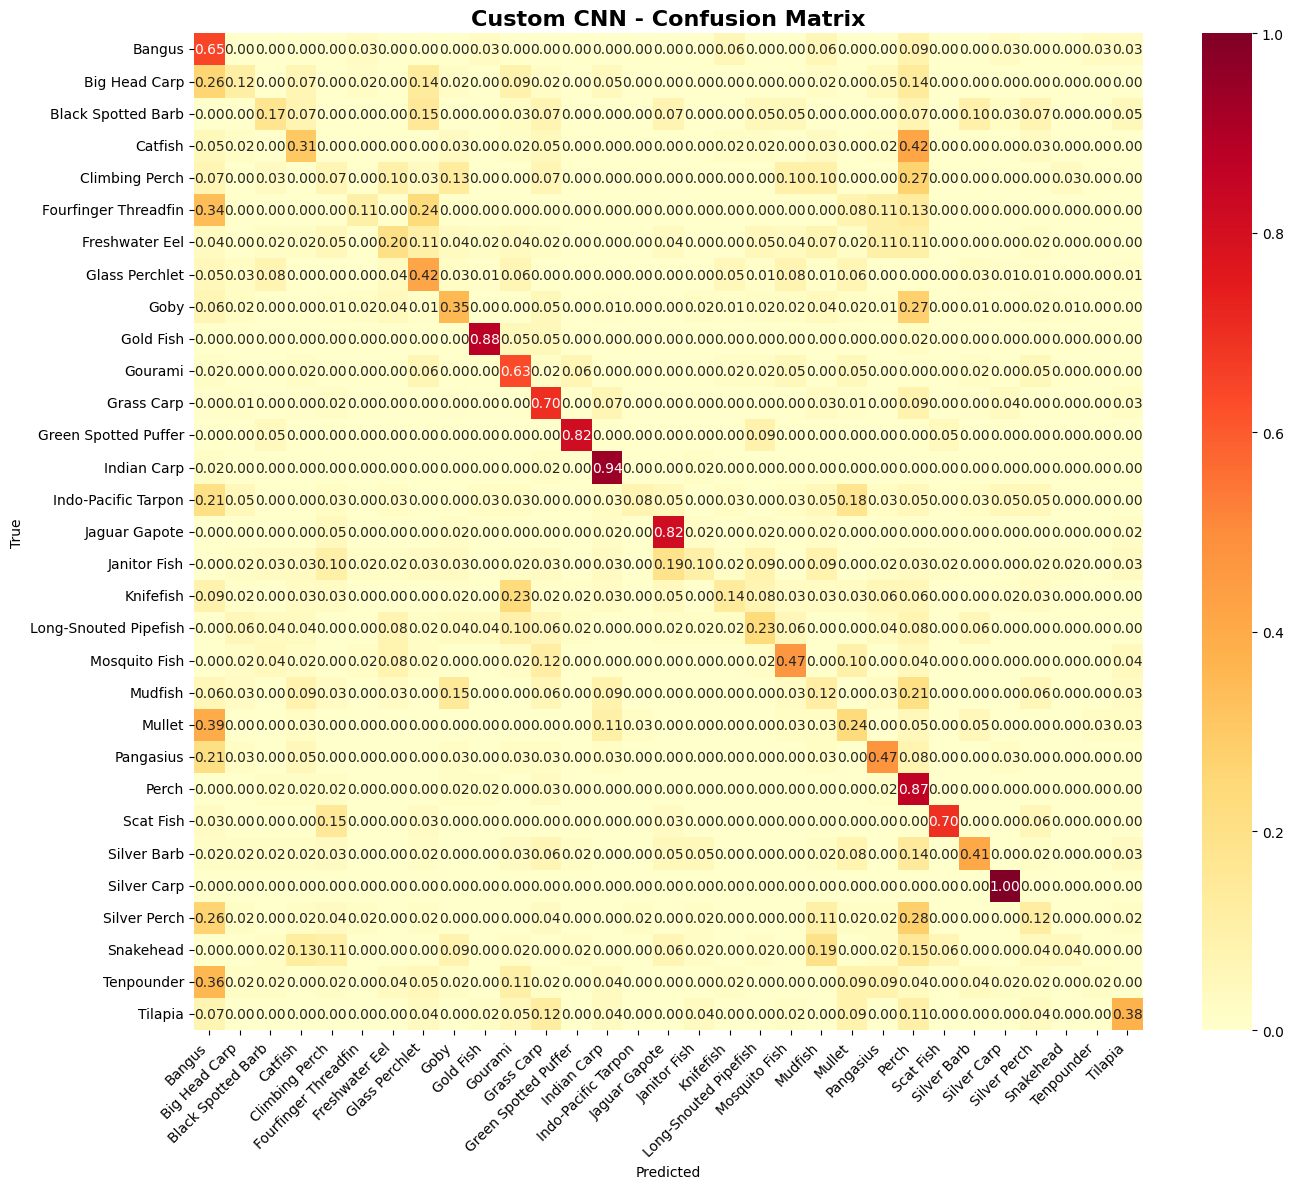


📊 Evaluating: Transfer Learning
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step

TEST ACCURACY: 93.75%

                       precision    recall  f1-score   support

               Bangus     0.8684    0.9706    0.9167        34
        Big Head Carp     0.8889    0.9302    0.9091        43
   Black Spotted Barb     0.8919    0.8250    0.8571        40
              Catfish     0.9355    0.9355    0.9355        62
       Climbing Perch     0.8286    0.9667    0.8923        30
 Fourfinger Threadfin     0.8780    0.9474    0.9114        38
       Freshwater Eel     0.9153    0.9818    0.9474        55
       Glass Perchlet     0.9726    0.9221    0.9467        77
                 Goby     0.9911    0.8952    0.9407       124
            Gold Fish     0.9762    1.0000    0.9880        41
              Gourami     1.0000    0.9683    0.9839        63
           Grass Carp     0.9866    0.9286    0.9567       238
 Green Spotted Puffer     1.0000    1.0000    1.0000        22
          Indian C

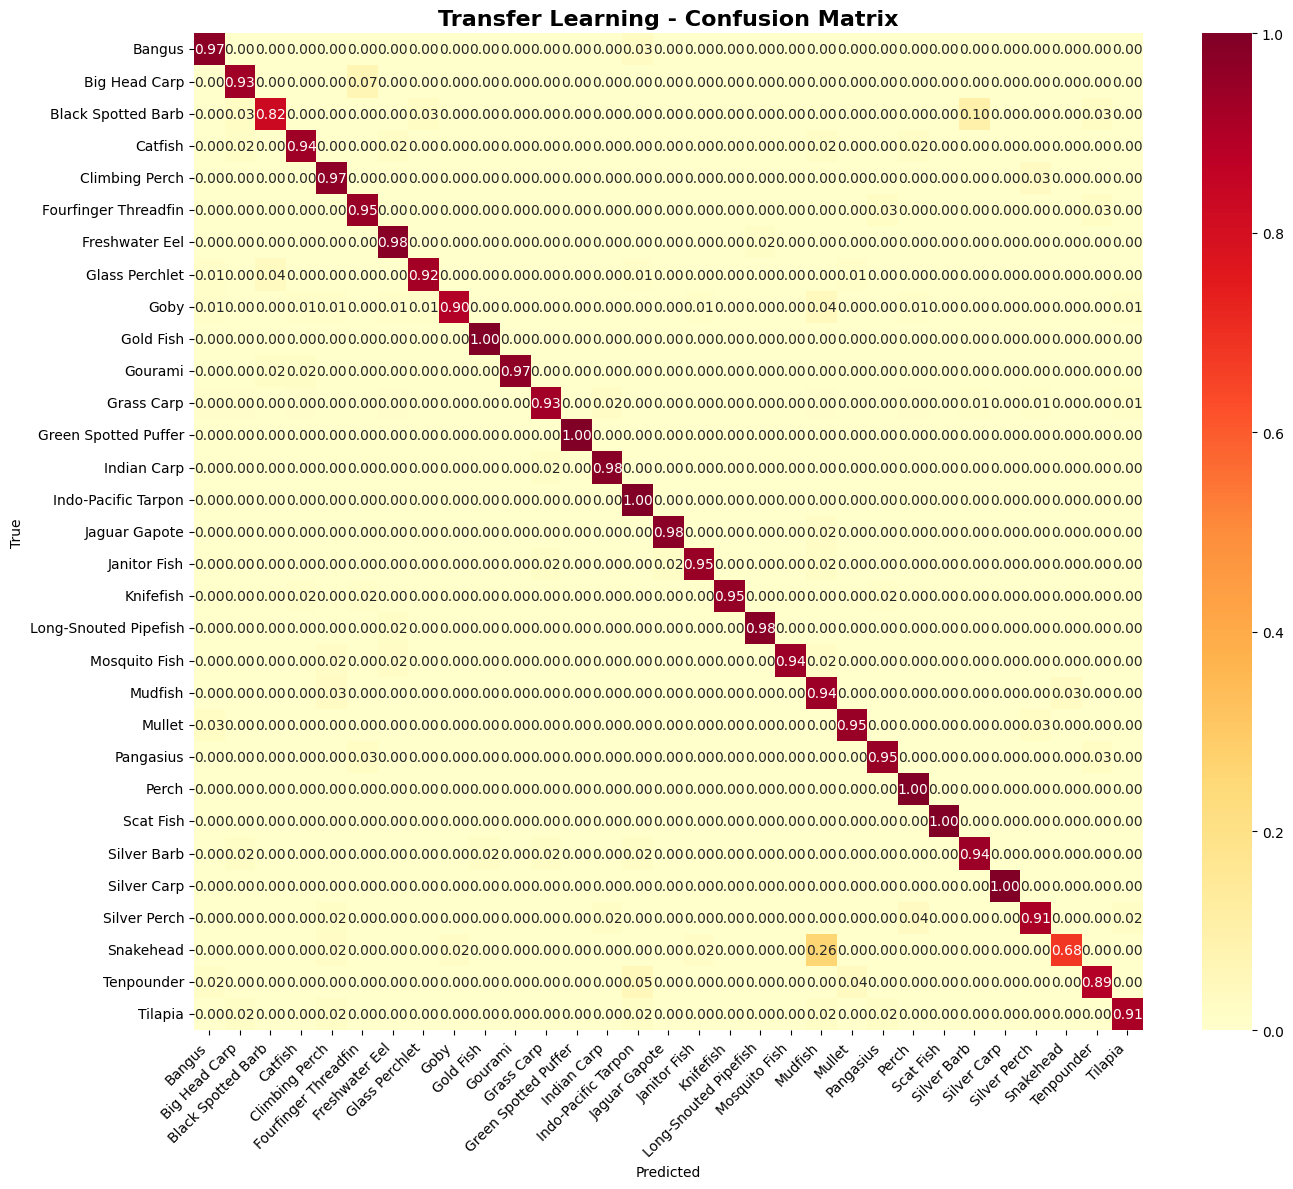

In [16]:
print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

def evaluate_model(model, generator, model_name):
    print(f"\n📊 Evaluating: {model_name}")
    generator.reset()
    y_pred_probs = model.predict(generator, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = generator.classes
    accuracy = accuracy_score(y_true, y_pred)

    print(f"\n{'='*70}")
    print(f"TEST ACCURACY: {accuracy*100:.2f}%")
    print(f"{'='*70}")
    print("\n" + classification_report(y_true, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(14, 12))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='YlOrRd',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return accuracy

custom_cnn_best = keras.models.load_model(os.path.join(checkpoint_dir, 'best_custom_cnn.h5'))
transfer_best = keras.models.load_model(os.path.join(checkpoint_dir, 'best_transfer_final.h5'))

acc_cnn = evaluate_model(custom_cnn_best, test_generator, "Custom CNN")
acc_transfer = evaluate_model(transfer_best, test_generator, "Transfer Learning")

##16. FINAL COMPARISON & RESULTS SUMMARY


FINAL COMPARISON
            Model  Test Accuracy (%)  Training Time (min)
       Custom CNN          43.068182             0.739500
Transfer Learning          93.750000             1.380159


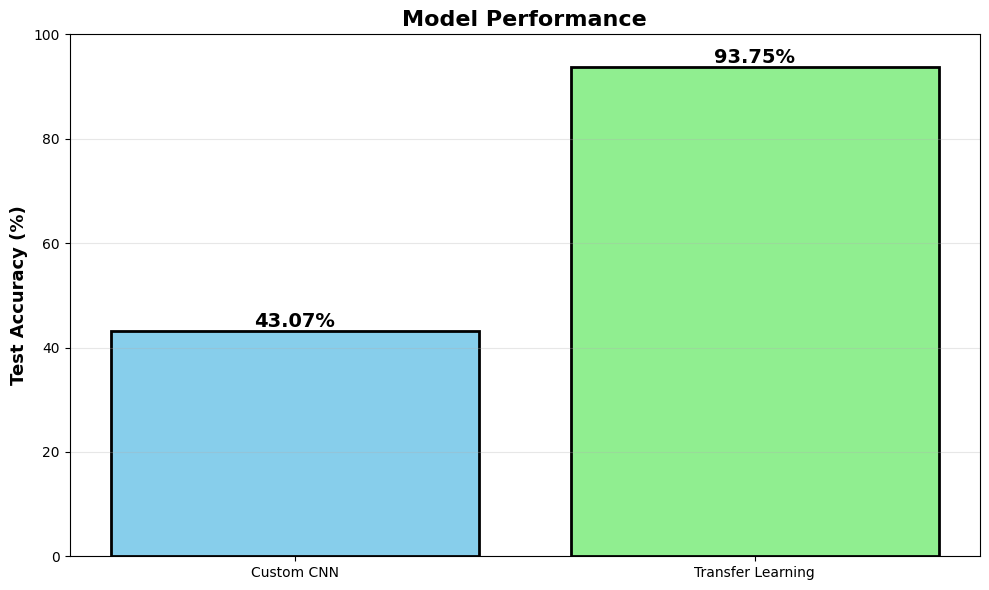


🏆 BEST MODEL: Transfer Learning
🎯 ACCURACY: 93.75%
⏱️  TOTAL TIME: 2.12 minutes

✅ TRAINING COMPLETED WITH AUTO-CHECKPOINT SYSTEM!
💾 All checkpoints saved in: /content/drive/MyDrive/ML/checkpoints


In [17]:
print("\n" + "="*70)
print("FINAL COMPARISON")
print("="*70)

comparison = pd.DataFrame({
    'Model': ['Custom CNN', 'Transfer Learning'],
    'Test Accuracy (%)': [acc_cnn*100, acc_transfer*100],
    'Training Time (min)': [cnn_time, t1_time + t2_time]
})

print(comparison.to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(comparison['Model'], comparison['Test Accuracy (%)'],
              color=['skyblue', 'lightgreen'], edgecolor='black', linewidth=2)
ax.set_ylabel('Test Accuracy (%)', fontsize=13, fontweight='bold')
ax.set_title('Model Performance', fontsize=16, fontweight='bold')
ax.set_ylim([0, 100])
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

best_model = comparison.loc[comparison['Test Accuracy (%)'].idxmax(), 'Model']
best_acc = comparison['Test Accuracy (%)'].max()

print(f"\n{'='*70}")
print(f"🏆 BEST MODEL: {best_model}")
print(f"🎯 ACCURACY: {best_acc:.2f}%")
print(f"⏱️  TOTAL TIME: {total_time:.2f} minutes")
print(f"{'='*70}")
print("\n✅ TRAINING COMPLETED WITH AUTO-CHECKPOINT SYSTEM!")
print(f"💾 All checkpoints saved in: {checkpoint_dir}")

##17. PREDICTION VISUALIZATION


PREDICTION VISUALIZATION

Visualizing predictions from best model...


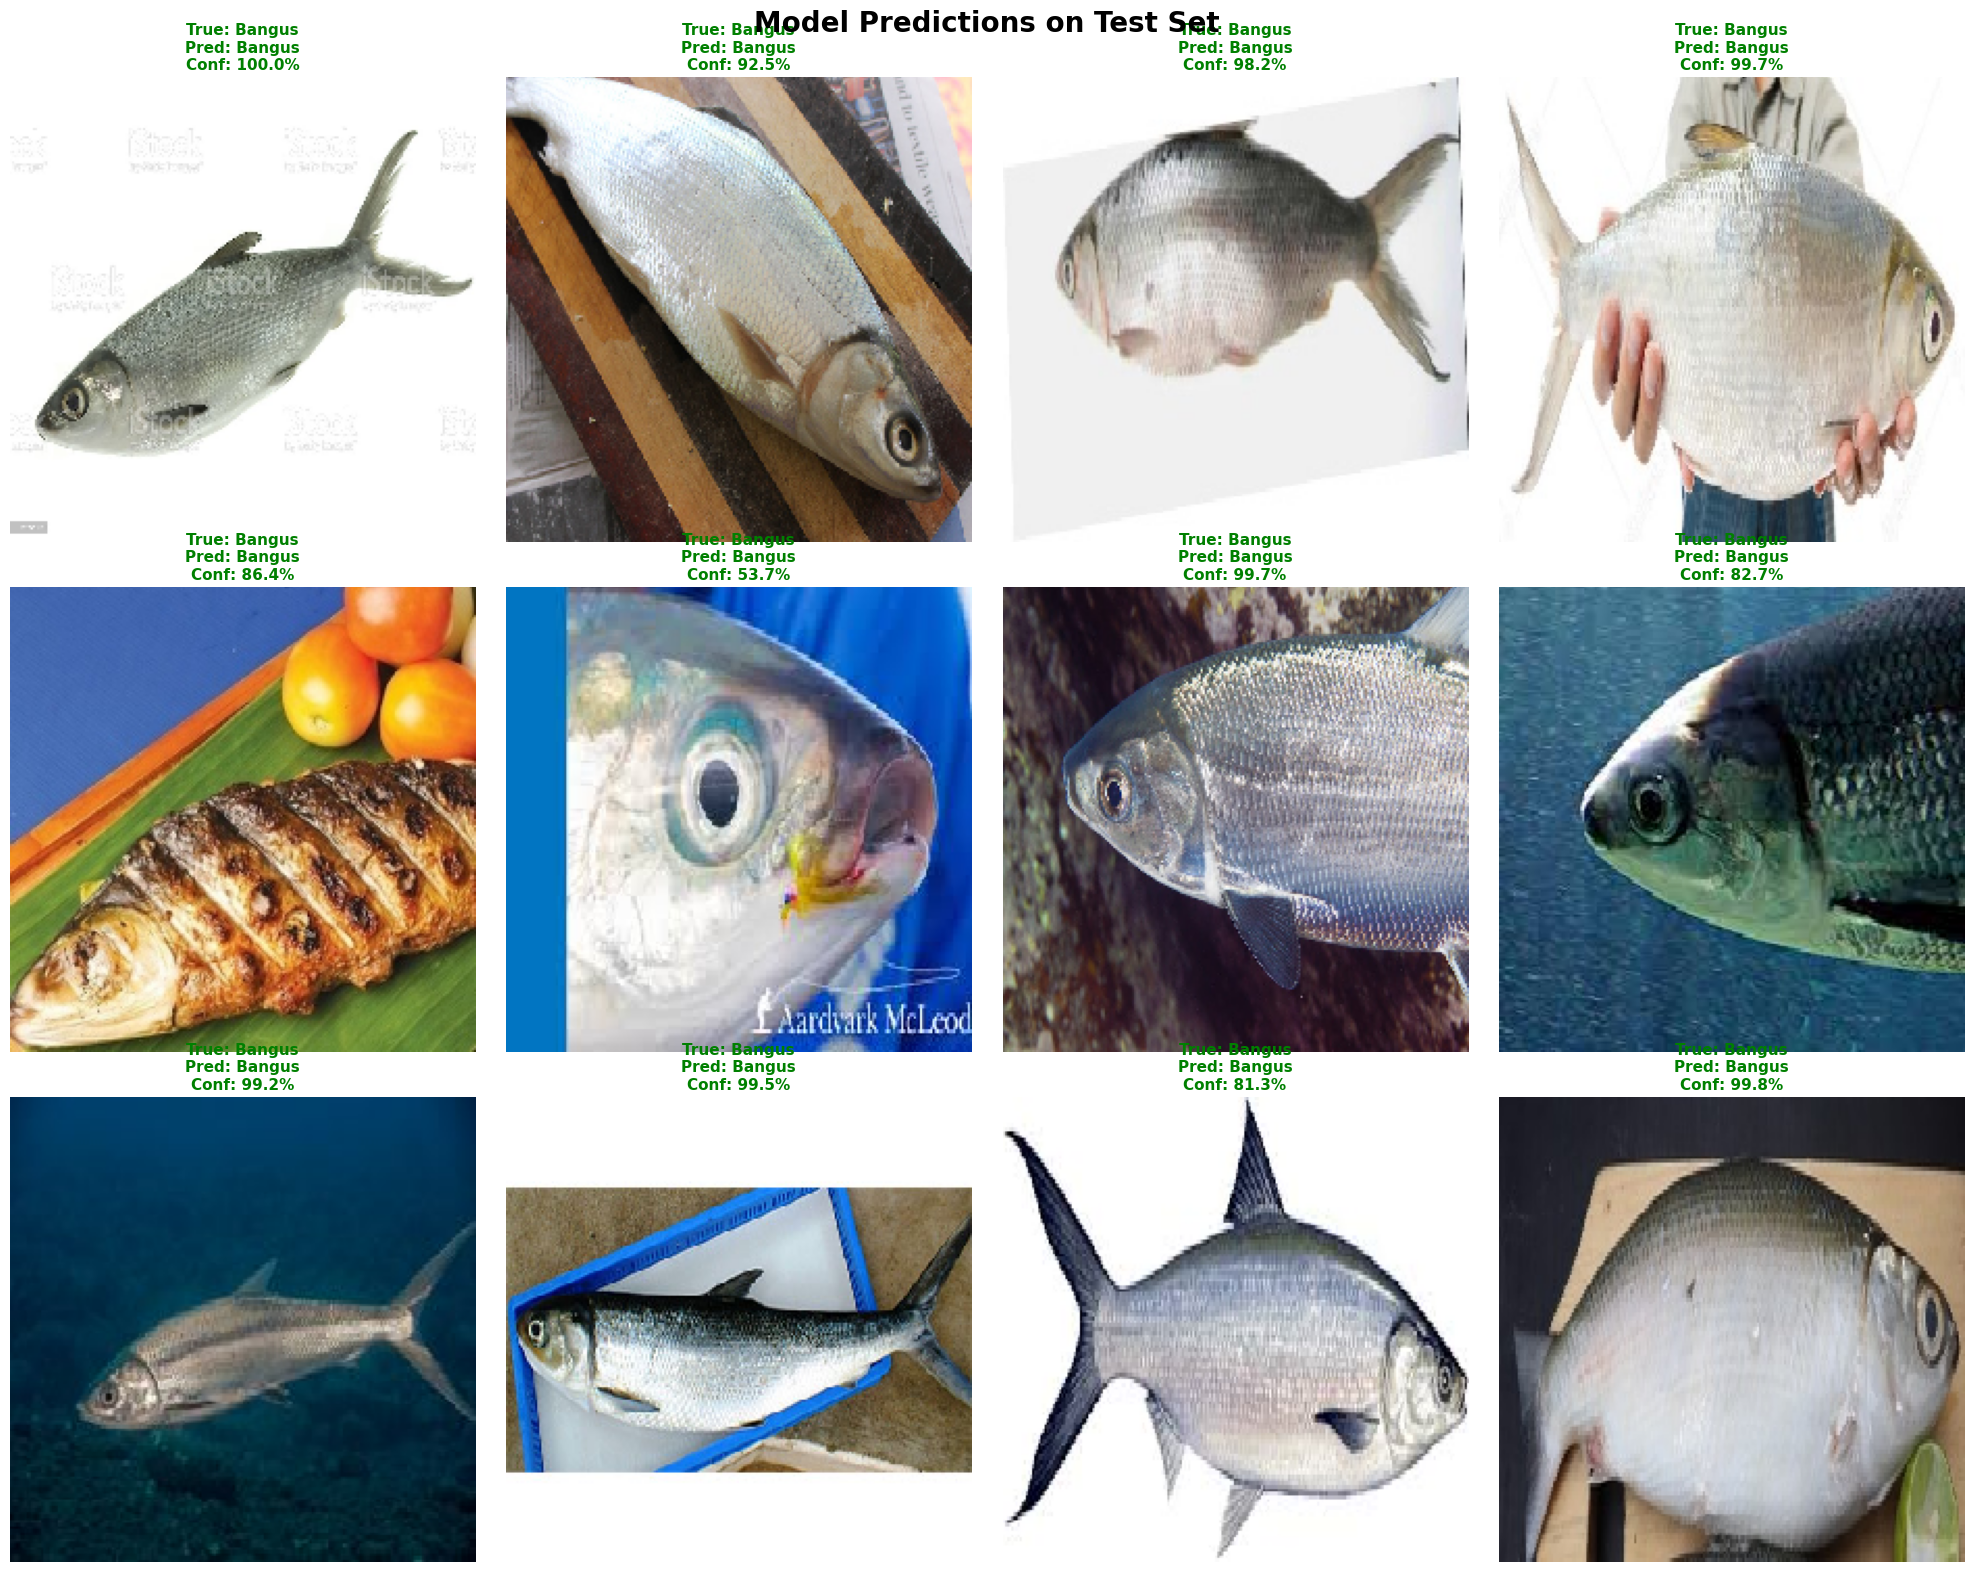

In [18]:
print("\n" + "="*70)
print("PREDICTION VISUALIZATION")
print("="*70)

def visualize_predictions(model, generator, class_names, n_samples=12):
    """Visualize model predictions with ground truth"""
    generator.reset()
    images, labels = next(generator)
    predictions = model.predict(images, verbose=0)

    fig, axes = plt.subplots(3, 4, figsize=(20, 16))
    fig.suptitle('Model Predictions on Test Set', fontsize=20, fontweight='bold')

    for i in range(min(n_samples, len(images))):
        ax = axes[i // 4, i % 4]
        ax.imshow(images[i])

        true_idx = np.argmax(labels[i])
        pred_idx = np.argmax(predictions[i])

        true_class = class_names[true_idx]
        pred_class = class_names[pred_idx]
        confidence = predictions[i][pred_idx] * 100

        # Green if correct, red if wrong
        color = 'green' if true_class == pred_class else 'red'
        title = f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%'

        ax.set_title(title, color=color, fontsize=11, fontweight='bold')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizing predictions from best model...")
visualize_predictions(transfer_best, test_generator, class_names, 12)

##18. SAVING FINAL ARTIFACTS

In [19]:
print("\n" + "="*70)
print("SAVING FINAL ARTIFACTS")
print("="*70)

# Save best model in multiple formats
final_model = transfer_best

# Save as .h5
final_model.save(os.path.join(base_path, 'fish_classification_final.h5'))
print("✅ Saved: fish_classification_final.h5")

# Save as .keras (new format)
final_model.save(os.path.join(base_path, 'fish_classification_final.keras'))
print("✅ Saved: fish_classification_final.keras")

# Save class indices
class_indices_save = train_generator.class_indices
with open(os.path.join(base_path, 'class_indices.json'), 'w') as f:
    json.dump(class_indices_save, f, indent=4)
print("✅ Saved: class_indices.json")

# Save comprehensive evaluation results
eval_results = {
    'dataset': {
        'num_classes': num_classes,
        'class_names': class_names,
        'train_samples': sum(train_dist.values()),
        'val_samples': sum(val_dist.values()),
        'test_samples': sum(test_dist.values())
    },
    'custom_cnn': {
        'test_accuracy': float(acc_cnn),
        'test_accuracy_percent': float(acc_cnn * 100),
        'training_time_minutes': float(cnn_time),
        'epochs': EPOCHS_CNN
    },
    'transfer_learning': {
        'test_accuracy': float(acc_transfer),
        'test_accuracy_percent': float(acc_transfer * 100),
        'training_time_minutes': float(t1_time + t2_time),
        'phase1_epochs': EPOCHS_T1,
        'phase2_epochs': EPOCHS_T2,
        'total_epochs': EPOCHS_T1 + EPOCHS_T2
    },
    'comparison': {
        'best_model': best_model,
        'best_accuracy': float(best_acc),
        'total_training_time_minutes': float(total_time),
        'total_training_time_hours': float(total_time / 60)
    },
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open(os.path.join(base_path, 'evaluation_results.json'), 'w') as f:
    json.dump(eval_results, f, indent=4)
print("✅ Saved: evaluation_results.json")


SAVING FINAL ARTIFACTS
✅ Saved: fish_classification_final.h5
✅ Saved: fish_classification_final.keras
✅ Saved: class_indices.json
✅ Saved: evaluation_results.json


##19. INFERENCE FUNCTION FOR SINGLE IMAGE PREDICTION

In [20]:
print("\n" + "="*70)
print("INFERENCE FUNCTION")
print("="*70)

def predict_single_image(model, image_path, class_names):
    """
    Predict single image and visualize results

    Usage:
        predicted_class, confidence = predict_single_image(
            final_model,
            '/path/to/fish_image.jpg',
            class_names
        )
    """
    # Load and preprocess image
    img = keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array, verbose=0)[0]
    top_idx = np.argmax(predictions)

    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Show image with prediction
    ax1.imshow(img)
    ax1.set_title(
        f'Predicted: {class_names[top_idx]}\nConfidence: {predictions[top_idx]*100:.2f}%',
        fontsize=16, fontweight='bold', color='green'
    )
    ax1.axis('off')

    # Show top-5 predictions
    top_5_idx = np.argsort(predictions)[-5:][::-1]
    top_5_probs = predictions[top_5_idx] * 100
    colors = ['green' if i == 0 else 'skyblue' for i in range(5)]

    ax2.barh(range(5), top_5_probs, color=colors, edgecolor='black', linewidth=1.5)
    ax2.set_yticks(range(5))
    ax2.set_yticklabels([class_names[i] for i in top_5_idx])
    ax2.set_xlabel('Probability (%)', fontsize=13, fontweight='bold')
    ax2.set_title('Top-5 Predictions', fontsize=14, fontweight='bold')
    ax2.invert_yaxis()

    # Add value labels
    for i, prob in enumerate(top_5_probs):
        ax2.text(prob + 1, i, f'{prob:.1f}%', va='center', fontweight='bold', fontsize=11)

    plt.tight_layout()
    plt.show()

    return class_names[top_idx], predictions[top_idx] * 100

print("✅ Inference function ready!")
print("\nUsage example:")
print("  predicted_class, confidence = predict_single_image(")
print("      final_model,")
print("      '/path/to/fish_image.jpg',")
print("      class_names")
print("  )")



INFERENCE FUNCTION
✅ Inference function ready!

Usage example:
  predicted_class, confidence = predict_single_image(
      final_model,
      '/path/to/fish_image.jpg',
      class_names
  )
